# MINI PROJETO - KMeans e DBSCAN - TITANIC SURVIVAL PREDICTION

### Projeto da cadeira de Sistemas Inteligentes (2023.2 - IF684EC - CIn - UFPE) que consiste em utilizar os algoritmos de KMeans e DBSCAN para agrupar os passageiros do Titanic em clusters.

### Desenvolvido por:

> Rafael do Nascimento Moura - rnm4@cin.ufpe.br

> Rodrigo Rocha Moura - rrm2@cin.ufpe.br

## Instalando dependências



In [ ]:
!pip install numpy pandas matplotlib scikit-learn seaborn

## Importando as bibliotecas

In [ ]:
import numpy as np # utilizada para
import pandas as pd # utilizada para analisar a base de dados
import matplotlib.pyplot as plt # utilizada para plotar gráficos
import seaborn as sns # utilizada para visualização de dados
import itertools #criar combinações para testes de parâmetros
import plotly.express as px #plotar gráfico dos clusters
from sklearn.cluster import KMeans # KMeans
from sklearn.cluster import DBSCAN # DBSCAN
from sklearn.preprocessing import StandardScaler # normalizador dos dados
from sklearn.metrics import silhouette_score # método da silhueta
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.decomposition import PCA  #redução de dimensões do dataset


## Analisando a base de dados

In [ ]:
titanic_data = pd.read_csv('data/titanic_unsupervised.csv') # titanic_data contém o conteúdo de treinamento

In [ ]:
titanic_data # uma breve visualização do conteúdo de treinamento

,Unnamed: 0,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


#### É importante entender cada variável para construir relações que ajudarão a resolver o problema. Desse modo, aqui está a descrição das colunas do dataframe:

> PassengerId: ID do passageiro.

> Pclass: A classe do ticket do passageiro, que pode ser primeira classe (1), segunda classe (2) e terceira classe (3).

> Name: Nome do passageiro.

> Sex: male (masculino) ou female (feminino).

> Age: Idade do passageiro. ***É fracionária se menor que 1. Se a idade for uma estimativa, então é da forma xx.5.***

> SibSp: Quantidade de passageiros que são das categorias irmão, irmã, meio-irmão, meio-irmã, marido, esposa.

> Parch: Quantidade de passageiros que são das categorias pai, mãe, filha, filho, enteada, enteado.

> Ticket: O código do ticket do passageiro.

> Fare: O preço da passagem do passageiro.

> Cabin: O número da cabine do passageiro.

> Embarked: O porto pelo qual o passageiro embarcou (C = Cherbourg, Q = Queenstown, S = Southampton).

In [ ]:
titanic_data.describe()

,Unnamed: 0,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,445.000000,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.500000,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,445.000000,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,667.500000,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,890.000000,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Analisando a coluna de sexo:**

In [ ]:
print(titanic_data['Sex'].value_counts(dropna = False)) # quantidade de homens e mulheres à bordo

male      577
female    314
Name: Sex, dtype: int64


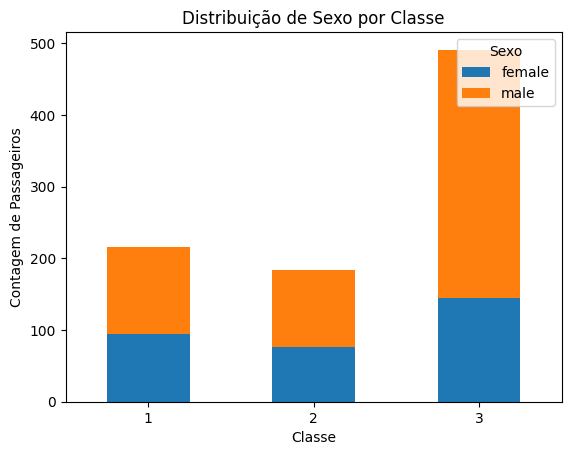

In [ ]:
sex_by_class = titanic_data.groupby(['Pclass', 'Sex']).size().unstack()

sex_by_class.plot(kind='bar', stacked=True)
plt.title('Distribuição de Sexo por Classe')
plt.xlabel('Classe')
plt.ylabel('Contagem de Passageiros')
plt.xticks(rotation=0)
plt.legend(title='Sexo', loc='upper right')
plt.show()

**Analisando a coluna da classe do passageiro:**

In [ ]:
print(titanic_data['Pclass'].value_counts(dropna = False)) # quantidade de passageiros por classe

3    491
1    216
2    184
Name: Pclass, dtype: int64


**Analisando a coluna do porto de embarque do passageiro:**

In [ ]:
print(titanic_data['Embarked'].value_counts(dropna = False)) # quantidade de embarques por portos

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64


<ipython-input-36-9439c4920a5c>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x = 'Pclass', col = 'Embarked', data = titanic_data, kind = 'count', palette = sns.color_palette("husl", 8)) # sobrevivência por classe e por porto de embarque
<ipython-input-36-9439c4920a5c>:1: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  g = sns.catplot(x = 'Pclass', col = 'Embarked', data = titanic_data, kind = 'count', palette = sns.color_palette("husl", 8)) # sobrevivência por classe e por porto de embarque


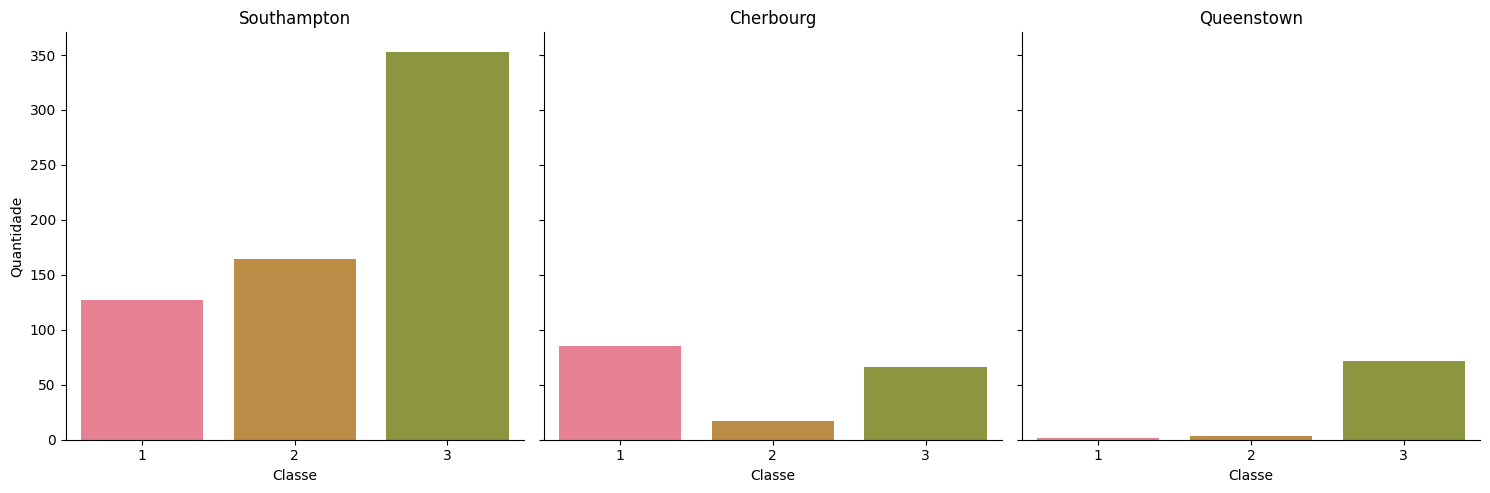

In [ ]:
g = sns.catplot(x = 'Pclass', col = 'Embarked', data = titanic_data, kind = 'count', palette = sns.color_palette("husl", 8)) # sobrevivência por classe e por porto de embarque

titulos = ['Southampton', 'Cherbourg', 'Queenstown']
for ax, titulo in zip(g.axes.flat, titulos):
    ax.set_title(titulo)
    ax.set_xlabel('Classe')
    ax.set_ylabel('Quantidade')

plt.show()

A partir da distribuição acima, podemos concluir que a maior parte dos passageiros da terceira classe embarcaram no porto de Southampton.

**Analisando a coluna de idade:**

Text(0.5, 1.0, 'Distribuição de Idade dos Passageiros')

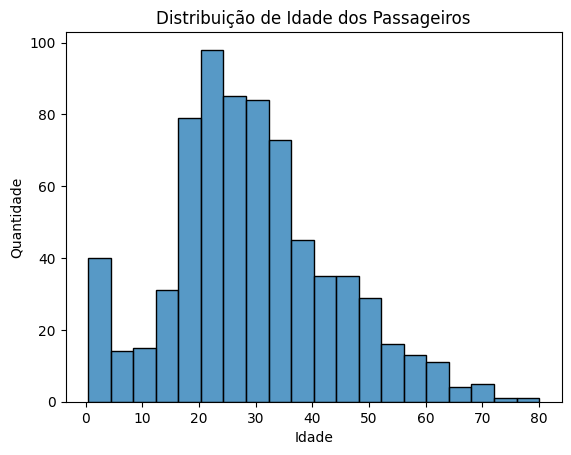

In [ ]:
sns.histplot(titanic_data['Age']) # histograma
plt.xlabel('Idade')
plt.ylabel('Quantidade')
plt.title('Distribuição de Idade dos Passageiros')

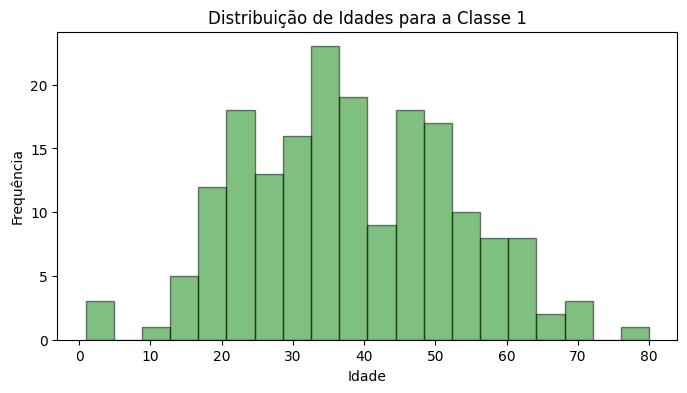

In [ ]:
# Seleciona as idades dos passageiros dessa classe
ages = titanic_data[titanic_data['Pclass'] == 1]['Age']

# Cria o histograma
plt.figure(figsize=(8, 4))
plt.hist(ages, bins=20, alpha=0.5, color='g', edgecolor='black')

plt.title('Distribuição de Idades para a Classe 1')
plt.xlabel('Idade')
plt.ylabel('Frequência')

plt.show()

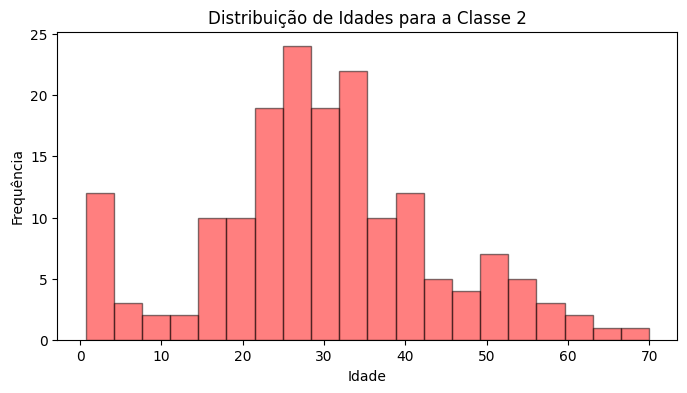

In [ ]:
# Seleciona as idades dos passageiros dessa classe
ages = titanic_data[titanic_data['Pclass'] == 2]['Age']

# Cria o histograma
plt.figure(figsize=(8, 4))
plt.hist(ages, bins=20, alpha=0.5, color='r', edgecolor='black')

plt.title('Distribuição de Idades para a Classe 2')
plt.xlabel('Idade')
plt.ylabel('Frequência')

plt.show()

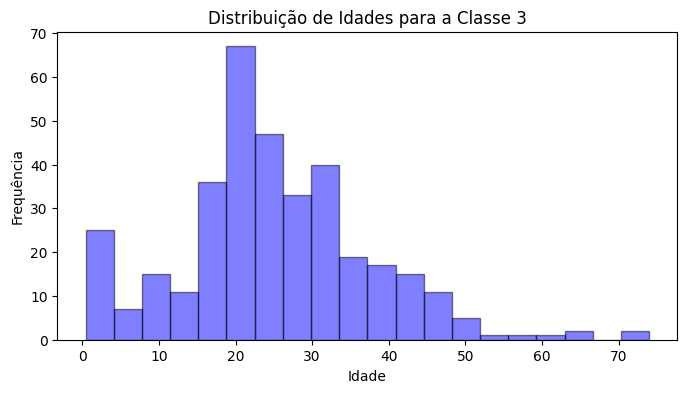

In [ ]:
# Seleciona as idades dos passageiros dessa classe
ages = titanic_data[titanic_data['Pclass'] == 3]['Age']

# Cria o histograma
plt.figure(figsize=(8, 4))
plt.hist(ages, bins=20, alpha=0.5, color='b', edgecolor='black')

plt.title('Distribuição de Idades para a Classe 3')
plt.xlabel('Idade')
plt.ylabel('Frequência')

plt.show()

**Explorando as correlações entre as variáveis numéricas:**

<Axes: >

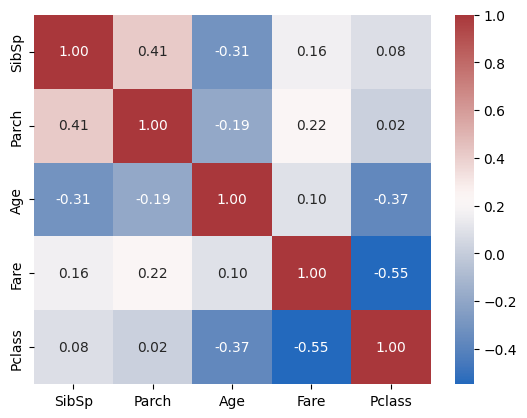

In [ ]:
sns.heatmap(titanic_data[['SibSp', 'Parch', 'Age', 'Fare', 'Pclass']].corr(), annot = True, fmt = '.2f', cmap = 'vlag')

Ao observar o heatmap acima, vemos que

1 - *Pclass* (classe social) e *Fare* (preço da passagem) possuem alta correlação negativa entre si. O que nos diz que uma pessoa pertencente a uma classe social mais alta (menor número) pagou mais pela passagem.

2 - *Parch* (quantidade de passageiros que são das categorias pai, mãe, filha, filho, enteada, enteado) e *SibSp* (quantidade de passageiros que são das categorias irmão, irmã, meio-irmão, meio-irmã, marido, esposa) possuem alta correlação positiva entre si. O que nos diz que uma pessoa que possui um maior número de *Parch* também implica em ter um maior número de *SibSp*.


## Tratando os dados

Temos valores faltando?

In [ ]:
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   891 non-null    int64  
 1   PassengerId  891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Temos valores faltando na coluna de Idade.

Assim, vamos preencher as células vazias com a média da coluna Idade do dataset.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin # mixa automaticamente as funções fit e transform sem ter que definir explicitamente
from sklearn.impute import SimpleImputer

class AgeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Preenche as idades faltantes com a média da coluna de idade
        imputer = SimpleImputer(strategy="mean")
        X['Age'] = imputer.fit_transform(X[['Age']])

        return X


Visando a análise do dataset pelo modelo, vamos transformar as variáveis de categorias em variáveis numéricas da seguinte maneira:

> Embarked C = 0

> Embarked S = 1

> Embarked Q = 2

> Embarked N = 3

> Sex Female = 0

> Sex Male = 1

In [ ]:
from sklearn.preprocessing import OneHotEncoder

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        encoder = OneHotEncoder()

        # Transform 'Embarked' column
        embarked_matrix = encoder.fit_transform(X[['Embarked']]).toarray()
        X['Embarked'] = embarked_matrix.argmax(axis=1)

        # Transform 'Sex' column
        sex_matrix = encoder.fit_transform(X[['Sex']]).toarray()
        X['Sex'] = sex_matrix.argmax(axis=1)

        return X


Também juntamos as colunas Pclass e Fare na coluna PclassFare. Além disso, juntamos as colunas SibSp e Parch na coluna Family.

In [ ]:
class ColumnCombiner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Combine Pclass and Fare into a new column 'PclassFare'
        X['PclassFare'] = X['Fare'] / X['Pclass']

        # Combine SibSp and Parch into a new column 'Family'
        X['Family'] = X['SibSp'] + X['Parch']

        return X

Também removemos as colunas que não afetam na resolução do problema: nome, código do ticket, cabine, classe do passageiro, id do passageiro, Unnamed: 0, Fare, SibSp, Parch.

In [ ]:
class FeatureDropper (BaseEstimator, TransformerMixin):

   def fit(self, X, y=None):
    return self

   def transform(self, X):
    return X.drop(["Name", "Ticket", "Cabin", "Pclass", "PassengerId", "Unnamed: 0", "Fare", "SibSp", "Parch"], axis = 1, errors="ignore")

In [ ]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([("ageimputer", AgeImputer()),("featureencoder", FeatureEncoder()),("columncombiner", ColumnCombiner()),("featuredropper", FeatureDropper())])

In [ ]:
titanic_data = pipeline.fit_transform(titanic_data)

Por fim, normalizamos os dados utilizando o StandardScaler(), que funciona da seguinte maneira:

z \= (x \- 𝜇)\/σ

onde z é o novo valor da célula, x é o valor antigo da célula, 𝜇 é o valor da média da coluna respectiva e σ é o valor do desvio padrão da coluna respectiva.

In [ ]:
scaler = StandardScaler()

titanic_data_normalized = scaler.fit_transform(titanic_data)

titanic_data = pd.DataFrame(titanic_data_normalized, columns=titanic_data.columns)

In [ ]:
titanic_data.info() # agora não há mais células vazias

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Sex         891 non-null    float64
 1   Age         891 non-null    float64
 2   Embarked    891 non-null    float64
 3   PclassFare  891 non-null    float64
 4   Family      891 non-null    float64
dtypes: float64(5)
memory usage: 34.9 KB


In [ ]:
titanic_data # visualizando as transformações no dataset

,Sex,Age,Embarked,PclassFare,Family
0,0.737695,-0.592481,0.581114,-0.441847,0.059160
1,-1.355574,0.638789,-1.938460,0.902763,0.059160
2,-1.355574,-0.284663,0.581114,-0.437454,-0.560975
3,-1.355574,0.407926,0.581114,0.547737,0.059160
4,0.737695,0.407926,0.581114,-0.436640,-0.560975
...,...,...,...,...,...
886,0.737695,-0.207709,0.581114,-0.362120,-0.560975
887,-1.355574,-0.823344,0.581114,0.096713,-0.560975
888,-1.355574,0.000000,0.581114,-0.336413,1.299429
889,0.737695,-0.284663,-1.938460,0.096713,-0.560975


## Experimentos:

Descrição dos parâmetros do KMeans:

- n_clusters: Número de clusters a serem criados pelo algoritmo, também conhecido como 'k'.

- init: Método de inicialização dos valores dos centróides.

- n_init: Quantas vezes deve-se rodar o algoritmo com diferentes valores iniciais de centróides.

- max_iter: Número máximo de iterações do algoritmo por rodada.

- tol: A tolerância para considerar convergência do algoritmo referente à diferença da norma entre os centróides de duas iterações consecutivas.

- random_state: Parâmetro que determina a aleatoriedade na geração dos valores iniciais dos centróides.

Encontrando o valor ótimo de 'k' por meio do método do cotovelo (Elbow Method):

In [ ]:
def elbow_method(data, max_k):
  means = []
  inertias = []

  for k in range(1, max_k):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(data)

    means.append(k)
    inertias.append(kmeans.inertia_)

  fig = plt.subplots(figsize = (10, 5))
  plt.plot(means, inertias, 'o-')
  plt.xlabel('k')
  plt.ylabel('inertia')
  plt.grid(True)
  plt.show()

Utilizando as variáveis Age, PclassFare e Family, vemos abaixo que o valor ótimo de k é 4.



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

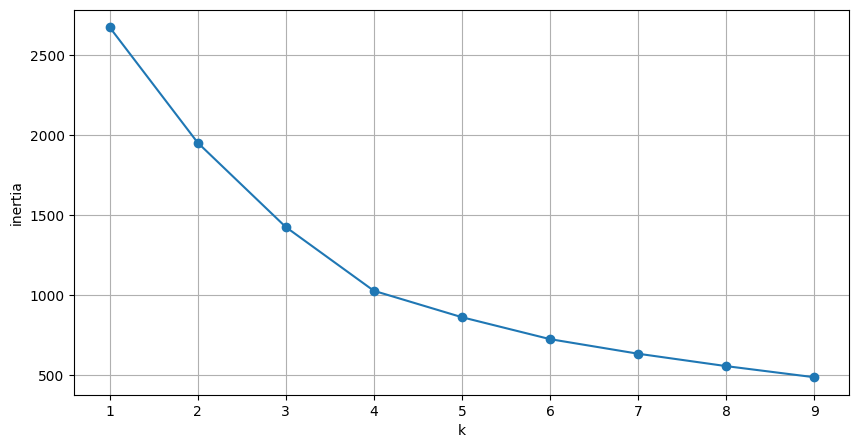

In [ ]:
elbow_method(titanic_data[['Age', 'PclassFare', 'Family']], 10)

Utilizando as variáveis Sex, PclassFare e Embarked, vemos abaixo que o valor ótimo de k é 4.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

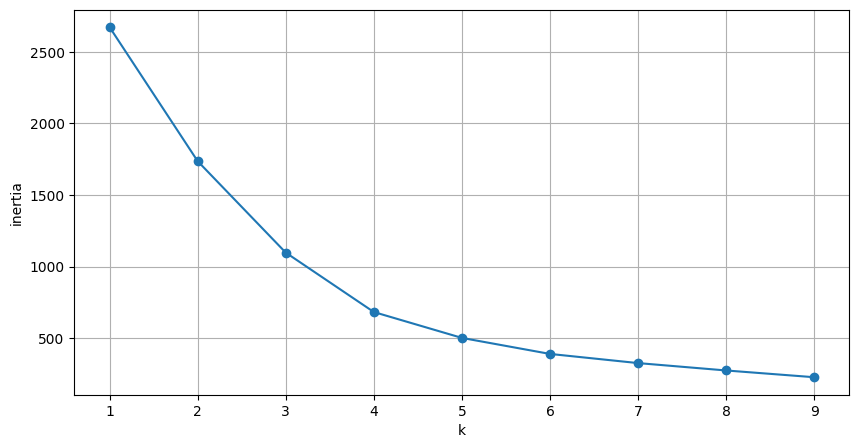

In [ ]:
elbow_method(titanic_data[['Sex', 'PclassFare', 'Embarked']], 10)

Utilizando as variáveis Sex e PclassFare, vemos abaixo que o valor ótimo de k é 3.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

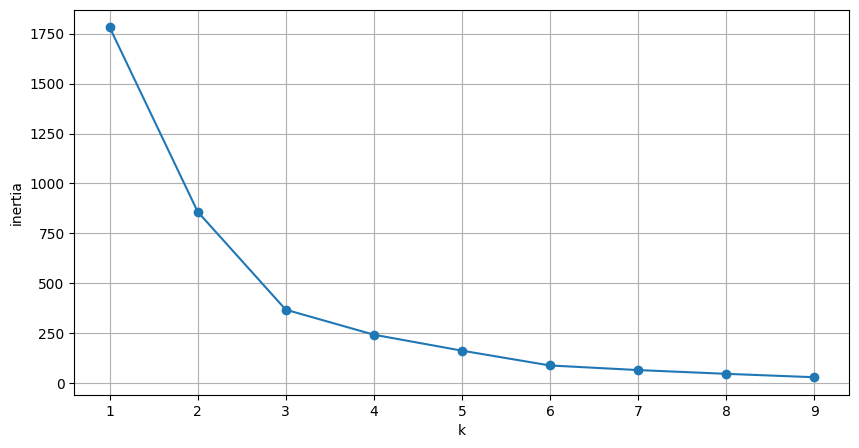

In [ ]:
elbow_method(titanic_data[['Sex', 'PclassFare']], 10)


Encontrando o valor ótimo de 'k' por meio do método da silhueta (Silhouette):

In [ ]:
def silhouette_method(data, max_k):

  sil_score = []
  for k in range(2, max_k):
      clusterer = KMeans(n_clusters=k)
      preds = clusterer.fit_predict(data)
      score = silhouette_score(data, preds)
      sil_score.append(score)

  plt.plot(range(2, max_k), sil_score, color='#EE9D65')

Utilizando as variáveis Age, PclassFare e Family, vemos abaixo que o valor ótimo de k é 3.




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

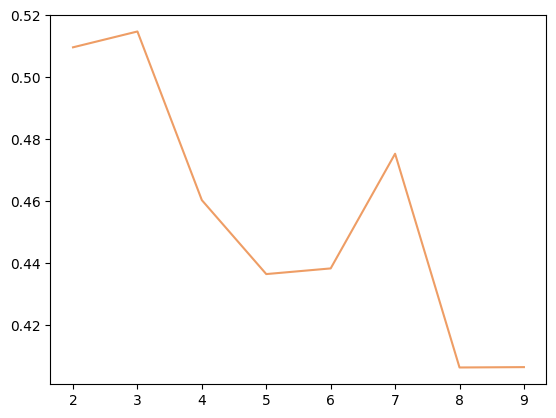

In [ ]:
silhouette_method(titanic_data[['Age', 'PclassFare', 'Family']], 10)

Utilizando as variáveis Sex, PclassFare e Embarked, vemos abaixo que o valor ótimo de k é 5.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

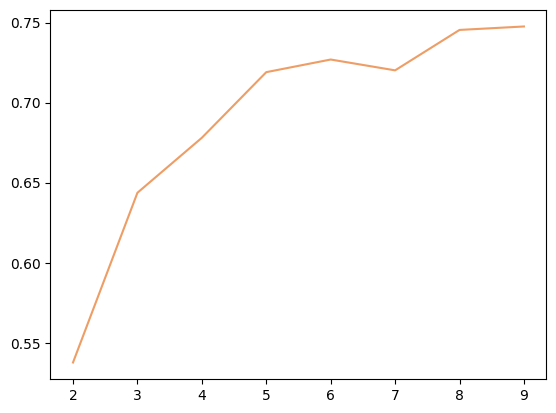

In [ ]:
silhouette_method(titanic_data[['Sex', 'PclassFare', 'Embarked']], 10)

Utilizando as variáveis Sex e PclassFare, vemos abaixo que o valor ótimo de k é 4.





/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

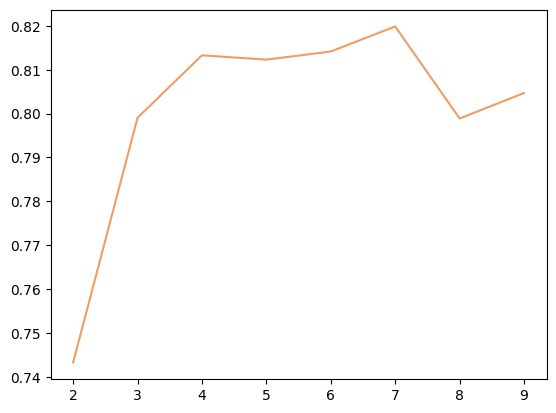

In [ ]:
silhouette_method(titanic_data[['Sex', 'PclassFare']], 10)

Resumo em relação aos métodos do cotovelo e da silhueta:

> Para as variáveis Age, PclassFare e Family: Elbow -> k = 4 | Silhouette -> k = 3

> Para as variáveis Sex, PclassFare e Embarked: Elbow -> k = 4 | Silhouette -> k = 5

> Para as variáveis Sex e PclassFare: Elbow -> k = 3 | Silhouette -> k = 4

A partir dos resultados dos experimentos acima, escolhemos k = 4. Assim, aplicando o K means clustering:

In [ ]:
kmeans = KMeans(n_clusters = 4, init = 'random', random_state = 42)

Considerando as variáveis Age, PclassFare e Family:

(Obs.: Neste gráfico, o tamanho dos pontos é proporcional à variável Family. Assim, é possível visualizar as três variáveis.)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


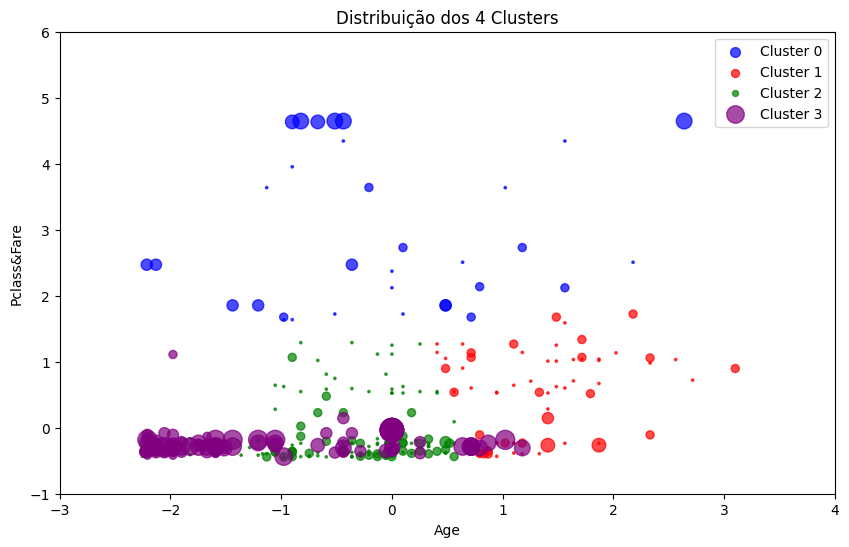

In [ ]:
kmeans.fit(titanic_data[['Age', 'PclassFare', 'Family']])
labels = kmeans.labels_

# Adicione os rótulos dos clusters como uma nova coluna no DataFrame
titanic_data['Cluster'] = labels

# Crie um scatter plot para visualizar os clusters
plt.figure(figsize=(10, 6))

# Scatter plot para o cluster 0
plt.scatter(titanic_data.loc[titanic_data['Cluster'] == 0, 'Age'],
            titanic_data.loc[titanic_data['Cluster'] == 0, 'PclassFare'],
            s=titanic_data.loc[titanic_data['Cluster'] == 0, 'Family'] * 50,  # Tamanho dos pontos baseado na variável Family
            label='Cluster 0', color='blue', alpha=0.7)

# Scatter plot para o cluster 1
plt.scatter(titanic_data.loc[titanic_data['Cluster'] == 1, 'Age'],
            titanic_data.loc[titanic_data['Cluster'] == 1, 'PclassFare'],
            s=titanic_data.loc[titanic_data['Cluster'] == 1, 'Family'] * 50,
            label='Cluster 1', color='red', alpha=0.7)

# Scatter plot para o cluster 2
plt.scatter(titanic_data.loc[titanic_data['Cluster'] == 2, 'Age'],
            titanic_data.loc[titanic_data['Cluster'] == 2, 'PclassFare'],
            s=titanic_data.loc[titanic_data['Cluster'] == 2, 'Family'] * 50,
            label='Cluster 2', color='green', alpha=0.7)

# Scatter plot para o cluster 3
plt.scatter(titanic_data.loc[titanic_data['Cluster'] == 3, 'Age'],
            titanic_data.loc[titanic_data['Cluster'] == 3, 'PclassFare'],
            s=titanic_data.loc[titanic_data['Cluster'] == 3, 'Family'] * 50,
            label='Cluster 3', color='purple', alpha=0.7)

plt.xlabel('Age')
plt.ylabel('PclassFare')
plt.xlim(-3, 4)
plt.ylim(-1, 6)
plt.title('Distribuição dos 4 Clusters')
plt.legend()
plt.show()

In [ ]:
cluster_stats = titanic_data.groupby('Cluster').describe()

for column in titanic_data.columns:
  if(column != 'Cluster'):
    mean_values = cluster_stats[column]['mean']
    std_values = cluster_stats[column]['std']
    min_values = cluster_stats[column]['min']
    max_values = cluster_stats[column]['max']
    print('\t\t'+column)
    for cluster in range(4):
      print(f"Cluster {cluster} - Média: {mean_values[cluster]:.2f}, Desvio Padrão: {std_values[cluster]:.2f}, Mínimo: {min_values[cluster]:.2f}, Máximo: {max_values[cluster]:.2f}")

		Sex
Cluster 0 - Média: -0.66, Desvio Padrão: 1.00, Mínimo: -1.36, Máximo: 0.74
Cluster 1 - Média: 0.08, Desvio Padrão: 0.98, Mínimo: -1.36, Máximo: 0.74
Cluster 2 - Média: 0.09, Desvio Padrão: 0.97, Mínimo: -1.36, Máximo: 0.74
Cluster 3 - Média: -0.36, Desvio Padrão: 1.05, Mínimo: -1.36, Máximo: 0.74
		Age
Cluster 0 - Média: 0.02, Desvio Padrão: 0.99, Mínimo: -2.21, Máximo: 2.64
Cluster 1 - Média: 1.53, Desvio Padrão: 0.68, Mínimo: 0.41, Máximo: 3.87
Cluster 2 - Média: -0.23, Desvio Padrão: 0.48, Mínimo: -2.25, Máximo: 0.72
Cluster 3 - Média: -1.17, Desvio Padrão: 1.01, Mínimo: -2.23, Máximo: 1.18
		Embarked
Cluster 0 - Média: -0.68, Desvio Padrão: 1.27, Mínimo: -1.94, Máximo: 0.58
Cluster 1 - Média: 0.04, Desvio Padrão: 1.04, Mínimo: -1.94, Máximo: 1.84
Cluster 2 - Média: 0.00, Desvio Padrão: 0.97, Mínimo: -1.94, Máximo: 0.58
Cluster 3 - Média: 0.26, Desvio Padrão: 0.80, Mínimo: -1.94, Máximo: 0.58
		Pclass&Fare
Cluster 0 - Média: 3.31, Desvio Padrão: 1.92, Mínimo: 1.64, Máximo: 9.5

Considerando as variáveis Sex, PclassFare:

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


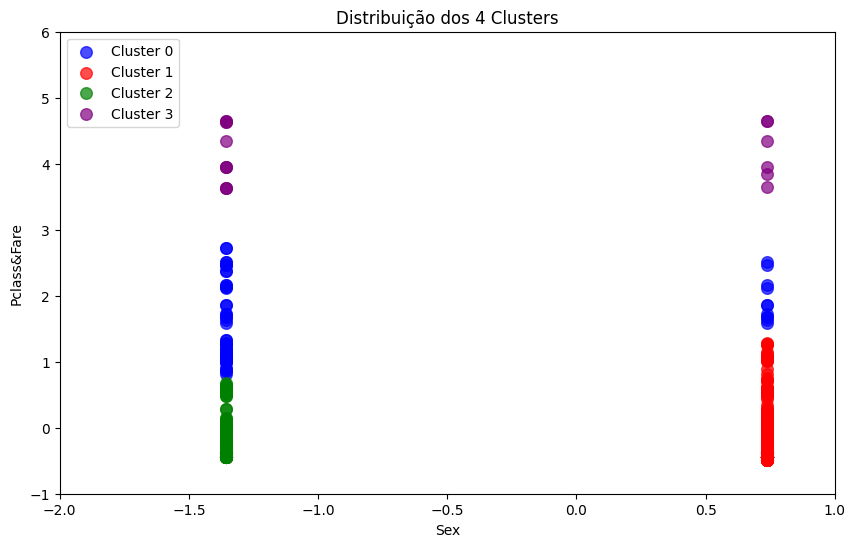

In [ ]:
kmeans.fit(titanic_data[['Sex', 'PclassFare']])
labels = kmeans.labels_

# Adicione os rótulos dos clusters como uma nova coluna no DataFrame
titanic_data['Cluster'] = labels

# Crie um scatter plot para visualizar os clusters
plt.figure(figsize=(10, 6))

# Scatter plot para o cluster 0
plt.scatter(titanic_data.loc[titanic_data['Cluster'] == 0, 'Sex'],
            titanic_data.loc[titanic_data['Cluster'] == 0, 'PclassFare'],
            label='Cluster 0', color='blue', alpha=0.7, s=70)

# Scatter plot para o cluster 1
plt.scatter(titanic_data.loc[titanic_data['Cluster'] == 1, 'Sex'],
            titanic_data.loc[titanic_data['Cluster'] == 1, 'PclassFare'],
            label='Cluster 1', color='red', alpha=0.7, s=70)

# Scatter plot para o cluster 2
plt.scatter(titanic_data.loc[titanic_data['Cluster'] == 2, 'Sex'],
            titanic_data.loc[titanic_data['Cluster'] == 2, 'PclassFare'],
            label='Cluster 2', color='green', alpha=0.7, s=70)

# Scatter plot para o cluster 3
plt.scatter(titanic_data.loc[titanic_data['Cluster'] == 3, 'Sex'],
            titanic_data.loc[titanic_data['Cluster'] == 3, 'PclassFare'],
            label='Cluster 3', color='purple', alpha=0.7, s=70)

plt.xlabel('Sex')
plt.ylabel('PclassFare')
plt.xlim(-2, 1)
plt.ylim(-1, 6)
plt.title('Distribuição dos 4 Clusters')
plt.legend()
plt.show()

In [ ]:
cluster_stats = titanic_data.groupby('Cluster').describe()

for column in titanic_data.columns:
  if(column != 'Cluster'):
    mean_values = cluster_stats[column]['mean']
    std_values = cluster_stats[column]['std']
    min_values = cluster_stats[column]['min']
    max_values = cluster_stats[column]['max']
    print('\t\t'+column)
    for cluster in range(4):
      print(f"Cluster {cluster} - Média: {mean_values[cluster]:.2f}, Desvio Padrão: {std_values[cluster]:.2f}, Mínimo: {min_values[cluster]:.2f}, Máximo: {max_values[cluster]:.2f}")

		Sex
Cluster 0 - Média: -1.01, Desvio Padrão: 0.79, Mínimo: -1.36, Máximo: 0.74
Cluster 1 - Média: 0.74, Desvio Padrão: 0.00, Mínimo: 0.74, Máximo: 0.74
Cluster 2 - Média: -1.36, Desvio Padrão: 0.00, Mínimo: -1.36, Máximo: -1.36
Cluster 3 - Média: -0.52, Desvio Padrão: 1.05, Mínimo: -1.36, Máximo: 0.74
		Age
Cluster 0 - Média: 0.35, Desvio Padrão: 1.10, Mínimo: -2.21, Máximo: 2.56
Cluster 1 - Média: 0.06, Desvio Padrão: 0.99, Mínimo: -2.25, Máximo: 3.87
Cluster 2 - Média: -0.23, Desvio Padrão: 0.96, Mínimo: -2.23, Máximo: 2.56
Cluster 3 - Média: 0.10, Desvio Padrão: 0.94, Mínimo: -1.13, Máximo: 2.64
		Embarked
Cluster 0 - Média: -0.62, Desvio Padrão: 1.32, Mínimo: -1.94, Máximo: 1.84
Cluster 1 - Média: 0.11, Desvio Padrão: 0.92, Mínimo: -1.94, Máximo: 0.58
Cluster 2 - Média: -0.01, Desvio Padrão: 0.96, Mínimo: -1.94, Máximo: 0.58
Cluster 3 - Média: -0.93, Desvio Padrão: 1.27, Mínimo: -1.94, Máximo: 0.58
		Pclass&Fare
Cluster 0 - Média: 1.58, Desvio Padrão: 0.57, Mínimo: 0.81, Máximo: 

Terminado os experimentos com K-Means, podemos olhar para soluções mais eficazes para lidar com problemas de clustering em dados aninhados e de alta dimensão, o algoritmo de clustering DBSCAN é uma opção! Ele introduz três conceitos cruciais e dois hiperparâmetros fundamentais:

Conceitos:

Ponto Central: Este é o ponto focal que abriga pelo menos um número mínimo de pontos de dados (minPts) em sua vizinhança, permitindo que o cluster se estenda além dessa região.

Ponto Não-Central: Ao contrário do ponto central, este não possui o número mínimo de pontos (minPts) em sua vizinhança, logo não pode expandir o cluster.

Outliers / Ruído: Estes são os pontos de dados que não se enquadram em nenhum cluster estabelecido.

Hiperparâmetros:

minPts: Representa o número mínimo de pontos de dados que devem estar presentes na vizinhança de um ponto para que seja considerado um ponto central.

Épsilon: Determina o raio da vizinhança de um ponto central, definindo a área em que outros pontos serão considerados membros do mesmo cluster.








O dataset atual normalizado, mesmo após a redução do número de features, ainda conta com 5 dimensões. Seria interessante, nesse momento, reduzir o número de dimensões de modo que seja possível tratar o problema de forma mais simples.

In [ ]:
pca = PCA(n_components = 2)
pca.fit(titanic_data)
data_pca = pca.transform(titanic_data)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2'])
data_pca.head()

,PC1,PC2
0,-0.660939,-0.842198
1,1.745844,1.670547
2,0.157099,-0.451524
3,0.784356,0.141163
4,-1.217120,0.031816


Para esse trabalho escolhemos o método PCA, que reduziu o original a duas dimensões PC1 e PC2

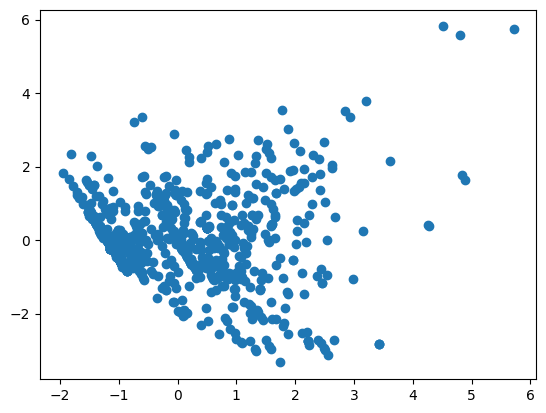

In [ ]:
plt.scatter(data_pca.PC1, data_pca.PC2)

Acima é possível ver a distribuição dos pontos no eixo cartesiano.

Podemos, inicialmente modelar o DBSCAN com essas duas dimensões e escolher "eps" e "min_samples" arbitrariamente como 0.2 e 15 apenas para uma primeira análise dos resultados.

In [ ]:
X = data_pca.to_numpy()

dbscan_cluster_model = DBSCAN(eps=0.2, min_samples=15).fit(X)
dbscan_cluster_model

DBSCAN(eps=0.2, min_samples=15)

In [ ]:
data_pca['cluster'] = dbscan_cluster_model.labels_

data_pca

,PC1,PC2,cluster
0,-0.660939,-0.842198,1
1,1.745844,1.670547,-1
2,0.157099,-0.451524,0
3,0.784356,0.141163,4
4,-1.217120,0.031816,1
...,...,...,...
886,-1.029655,-0.302671,1
887,0.551273,-0.529651,0
888,1.077510,-1.052938,-1
889,0.058224,1.089915,-1


Temos, então, a distribuição dos clusters da seguinte forma:

In [ ]:
data_pca['cluster'].value_counts()

-1    385
 1    354
 0     74
 2     38
 3     24
 4     16
Name: cluster, dtype: int64

A primeira vista, é possível notar que muitos pontos não foram relacionados a nenhum cluster (-1). Podemos analisar a representação visual:

In [ ]:
fig = px.scatter(x=data_pca.PC1, y=data_pca.PC2, color=data_pca['cluster'])

fig.show()

Usando o método de score silhouette, é possível determinar uma pontuação para esses clusters:

In [ ]:
silhouette_score(X, data_pca['cluster'])

0.10105272148214801

Considerando que o score máximo é 1 e o mínimo -1, é possível notar que essa disposição de clusters teve uma pontuação mediana.

Iremos agora, então, definir uma forma para escolher os melhores hiperparâmetros eps e min_samples de modo a obter o melhor score possível.

In [ ]:
epss = np.linspace(0.01, 1, num=15)
epss


array([0.01      , 0.08071429, 0.15142857, 0.22214286, 0.29285714,
       0.36357143, 0.43428571, 0.505     , 0.57571429, 0.64642857,
       0.71714286, 0.78785714, 0.85857143, 0.92928571, 1.        ])

In [ ]:
min_samples = np.arange(2, 20, step=3)
min_samples

array([ 2,  5,  8, 11, 14, 17])

In [ ]:
combinations = list(itertools.product(epss, min_samples))
combinations

[(0.01, 2),
 (0.01, 5),
 (0.01, 8),
 (0.01, 11),
 (0.01, 14),
 (0.01, 17),
 (0.08071428571428571, 2),
 (0.08071428571428571, 5),
 (0.08071428571428571, 8),
 (0.08071428571428571, 11),
 (0.08071428571428571, 14),
 (0.08071428571428571, 17),
 (0.15142857142857144, 2),
 (0.15142857142857144, 5),
 (0.15142857142857144, 8),
 (0.15142857142857144, 11),
 (0.15142857142857144, 14),
 (0.15142857142857144, 17),
 (0.22214285714285714, 2),
 (0.22214285714285714, 5),
 (0.22214285714285714, 8),
 (0.22214285714285714, 11),
 (0.22214285714285714, 14),
 (0.22214285714285714, 17),
 (0.29285714285714287, 2),
 (0.29285714285714287, 5),
 (0.29285714285714287, 8),
 (0.29285714285714287, 11),
 (0.29285714285714287, 14),
 (0.29285714285714287, 17),
 (0.3635714285714286, 2),
 (0.3635714285714286, 5),
 (0.3635714285714286, 8),
 (0.3635714285714286, 11),
 (0.3635714285714286, 14),
 (0.3635714285714286, 17),
 (0.4342857142857143, 2),
 (0.4342857142857143, 5),
 (0.4342857142857143, 8),
 (0.4342857142857143, 11),
 

Dessa forma definimos todas as combinações possível para o intervalo de epss e min_samples que definimos.

Considerando isso, temos a função get_scores_and_labels, que compara os scores de cada uma dessas combinações e retorna o melhor score com seus respectivos esp, min_samples e labels.

In [ ]:
def get_scores_and_labels(combinations, X):
  scores = []
  all_labels_list = []

  for i, (eps, num_samples) in enumerate(combinations):
    dbscan_cluster_model = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
    labels = dbscan_cluster_model.labels_
    labels_set = set(labels)
    num_clusters = len(labels_set)
    if -1 in labels_set:
      num_clusters -= 1

    # Se o modelo possuir menos de 2 clusters ou mais de 50 ele é descartado
    if (num_clusters < 2) or (num_clusters > 50):
      scores.append(-10)
      all_labels_list.append('ruim')
      c = (eps, num_samples)
      continue

    scores.append(silhouette_score(X, labels))
    all_labels_list.append(labels)

  best_index = np.argmax(scores)
  best_parameters = combinations[best_index]
  best_labels = all_labels_list[best_index]
  best_score = scores[best_index]

  return {'best_epsilon': best_parameters[0],
          'best_min_samples': best_parameters[1],
          'best_labels': best_labels,
          'best_score': best_score}

best_dict = get_scores_and_labels(combinations, X)

In [ ]:
best_dict

{'best_epsilon': 1.0,
 'best_min_samples': 2,
 'best_labels': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Com isso o melhor score alcançado foi 0,54 com eps = 1 e min_samples = 2.

A disposição dos clusters ficou definida dessa forma:

In [ ]:
data_pca['cluster'] = best_dict['best_labels']

data_pca['cluster'].value_counts()

0    884
2      3
1      2
3      2
Name: cluster, dtype: int64

Visualmente, temos:

In [ ]:
fig = px.scatter(x=data_pca.PC1, y=data_pca.PC2, color=data_pca['cluster'])
fig.show()

In [ ]:
data_pca

,PC1,PC2,cluster
0,-0.660939,-0.842198,0
1,1.745844,1.670547,0
2,0.157099,-0.451524,0
3,0.784356,0.141163,0
4,-1.217120,0.031816,0
...,...,...,...
886,-1.029655,-0.302671,0
887,0.551273,-0.529651,0
888,1.077510,-1.052938,0
889,0.058224,1.089915,0


In [ ]:
cluster_stats = data_pca.groupby('cluster').describe()
cluster_stats

PC1                                                              \
         count      mean       std       min       25%       50%       75%   
cluster                                                                      
0        884.0 -0.037665  1.117495 -1.953609 -0.991931 -0.270592  0.755109   
1          2.0  4.266614  0.013337  4.257183  4.261899  4.266614  4.271330   
2          3.0  5.009888  0.628088  4.510044  4.657379  4.804714  5.259810   
3          2.0  4.866385  0.040012  4.838093  4.852239  4.866385  4.880532   

                     PC2                                                    \
              max  count      mean       std       min       25%       50%   
cluster                                                                      
0        3.620155  884.0 -0.024151  1.094667 -3.327796 -0.609926 -0.115342   
1        4.276045    2.0  0.395523  0.032578  0.372487  0.384005  0.395523   
2        5.714905    3.0  5.714706  0.116248  5.586400  5.665551  5.744701   
3        4.894678    2.0  1.707082  0.097735  1.637973  1.672528  1.707082   

                             
              75%       max  
cluster                      
0        0.539675  3.797674  
1        0.407042  0.418560  
2        5.778859  5.813017  
3        1.741637  1.776191

Iremos agora repetir o experimento, porém sem diminuir o número de dimensões por meio do PCA. Serão consideradas as 5 features selecionadas após o processo de feature engineering.

In [ ]:
X = titanic_data.to_numpy()

dbscan_cluster_model = DBSCAN(eps=0.2, min_samples=15).fit(X)
dbscan_cluster_model

DBSCAN(eps=0.2, min_samples=15)

In [ ]:
titanic_data['cluster'] = dbscan_cluster_model.labels_

titanic_data

,Sex,Age,Embarked,PclassFare,Family,cluster
0,0.737695,-0.592481,0.581114,-0.441847,0.059160,-1
1,-1.355574,0.638789,-1.938460,0.902763,0.059160,-1
2,-1.355574,-0.284663,0.581114,-0.437454,-0.560975,4
3,-1.355574,0.407926,0.581114,0.547737,0.059160,-1
4,0.737695,0.407926,0.581114,-0.436640,-0.560975,0
...,...,...,...,...,...,...
886,0.737695,-0.207709,0.581114,-0.362120,-0.560975,0
887,-1.355574,-0.823344,0.581114,0.096713,-0.560975,-1
888,-1.355574,0.000000,0.581114,-0.336413,1.299429,-1
889,0.737695,-0.284663,-1.938460,0.096713,-0.560975,-1


In [ ]:
titanic_data['cluster'].value_counts()

-1    554
 0    237
 1     23
 2     21
 4     20
 3     20
 5     16
Name: cluster, dtype: int64

Essa é a disposição dos clusters, assim como na primeira vez, muitos outliers nessa configuração de hiperparâmetros.

In [ ]:
silhouette_score(X, titanic_data['cluster'])

-0.13782500203567122

A pontuação foi abaixo da média.

Realizando o mesmo processo de hypertuning de antes considerando os mesmos intervalos para os parâmetros, temos:

In [ ]:
best_dict = get_scores_and_labels(combinations, X)

In [ ]:
best_dict

{'best_epsilon': 0.7878571428571429,
 'best_min_samples': 8,
 'best_labels': array([ 0,  7,  1,  1,  0,  2,  0,  0,  1,  3,  1,  1,  0, -1,  1,  1, -1,
         0,  1,  3,  0,  0,  5,  0,  1, -1,  4, -1,  5,  0,  4, -1,  5,  0,
        -1,  0,  4,  0,  1,  3,  1,  1,  4, -1,  5,  0,  2,  5,  4,  1,  6,
         0,  8,  1, -1,  0,  1,  4,  1,  6,  4, -1,  0,  6,  4,  4,  1,  0,
         9,  0,  0,  9,  0,  4,  0,  0,  0,  0,  0,  1,  0,  0,  5,  0,  1,
         1,  6,  0, -1,  0,  0,  0,  0,  0,  0,  0, -1, -1,  1,  0,  1,  0,
         0,  0,  0,  0,  1,  0,  0,  5,  0,  3,  0,  1,  3,  0, -1,  0, -1,
         9,  0,  0,  4,  1,  0, -1,  2,  0,  3,  0,  4,  0,  1,  1,  0,  4,
         1,  0,  0, -1,  3,  1,  1,  2,  0,  0,  0,  1,  0,  0,  0,  1,  0,
         0,  0, -1,  5,  0,  0, -1,  0,  1,  0,  0,  6,  0,  1, -1,  0,  0,
         0, -1,  1,  0, -1,  0,  0, -1,  0,  0, -1,  4,  6,  0,  1,  0,  5,
         0, -1,  0,  1,  0,  1,  0, -1, -1,  2,  0,  5,  1,  0, -1,  0,  4,
         0, 

O melhor score foi 0,21 com eps de 0.7878571428571429 e min_samples de 8

In [ ]:
titanic_data['cluster'] = best_dict['best_labels']

titanic_data['cluster'].value_counts()

 0    408
 1    163
-1    117
 4     63
 5     34
 2     32
 3     26
 7     16
 6     15
 9      9
 8      8
Name: cluster, dtype: int64

In [ ]:
cluster_stats = titanic_data.groupby('cluster').describe()
cluster_stats

Sex                                                        \
         count      mean           std       min       25%       50%   
cluster                                                                
-1       117.0 -0.299994  1.051098e+00 -1.355574 -1.355574  0.737695   
 0       408.0  0.737695  1.111586e-16  0.737695  0.737695  0.737695   
 1       163.0 -1.355574  2.227289e-16 -1.355574 -1.355574 -1.355574   
 2        32.0  0.737695  0.000000e+00  0.737695  0.737695  0.737695   
 3        26.0 -1.355574  2.264420e-16 -1.355574 -1.355574 -1.355574   
 4        63.0  0.737695  2.238281e-16  0.737695  0.737695  0.737695   
 5        34.0 -1.355574  2.253838e-16 -1.355574 -1.355574 -1.355574   
 6        15.0  0.737695  0.000000e+00  0.737695  0.737695  0.737695   
 7        16.0 -1.355574  0.000000e+00 -1.355574 -1.355574 -1.355574   
 8         8.0 -1.355574  0.000000e+00 -1.355574 -1.355574 -1.355574   
 9         9.0 -1.355574  0.000000e+00 -1.355574 -1.355574 -1.355574   

                               Age            ... PclassFare           Family  \
              75%       max  count      mean  ...        75%       max  count   
cluster                                       ...                               
-1       0.737695  0.737695  117.0  0.415181  ...   2.371762  9.514110  117.0   
 0       0.737695  0.737695  408.0  0.080091  ...  -0.305986  1.268203  408.0   
 1      -1.355574 -1.355574  163.0 -0.165885  ...  -0.232768  1.336540  163.0   
 2       0.737695  0.737695   32.0 -0.024995  ...  -0.438464 -0.331857   32.0   
 3      -1.355574 -1.355574   26.0 -0.730425  ...  -0.356717  0.116238   26.0   
 4       0.737695  0.737695   63.0 -0.015961  ...  -0.105450  1.009093   63.0   
 5      -1.355574 -1.355574   34.0 -0.175391  ...  -0.436247 -0.331857   34.0   
 6       0.737695  0.737695   15.0 -1.664711  ...  -0.207264 -0.183793   15.0   
 7      -1.355574 -1.355574   16.0 -0.102876  ...   1.610661  2.159186   16.0   
 8      -1.355574 -1.355574    8.0  1.725769  ...   1.039113  1.134620    8.0   
 9      -1.355574 -1.355574    9.0 -1.627089  ...  -0.285485 -0.183793    9.0   

                                                                               
             mean       std       min       25%       50%       75%       max  
cluster                                                                        
-1       0.901907  1.613135 -0.560975  0.059160  0.679295  1.299429  5.640372  
 0      -0.348184  0.453814 -0.560975 -0.560975 -0.560975 -0.560975  1.919564  
 1       0.101009  0.726368 -0.560975 -0.560975  0.059160  0.679295  2.539699  
 2      -0.444700  0.292039 -0.560975 -0.560975 -0.560975 -0.560975  0.679295  
 3       0.106863  0.579700 -0.560975 -0.560975  0.059160  0.679295  1.299429  
 4      -0.364107  0.428853 -0.560975 -0.560975 -0.560975 -0.560975  1.299429  
 5      -0.378582  0.390105 -0.560975 -0.560975 -0.560975 -0.560975  0.679295  
 6       2.953122  0.605190  1.919564  2.539699  2.539699  3.469901  3.779968  
 7      -0.328424  0.310067 -0.560975 -0.560975 -0.560975  0.059160  0.059160  
 8       0.059160  0.000000  0.059160  0.059160  0.059160  0.059160  0.059160  
 9       3.090930  0.372655  2.539699  3.159833  3.159833  3.159833  3.779968  

[11 rows x 40 columns]